# Examples and a Few More Features

* Today, we'll work through some more-realistic examples of using Pandas.
* We'll touch on Seaborn (a plotting library), and statsmodels (a statistics library), which you can use to create beautiful plots, and complex econometric models.  But a lot of that content lives in other classes.
* This course is more about data retrieval, preparation, and presentation, than analysis.  So the examples are focussed accordingly.  Let's see how far we can get in 80 minutes.

## Direct Child Engagement

As we're getting started, please download the data:

http://www.bls.gov/tus/special.requests/atusact_0315.zip
http://www.bls.gov/tus/special.requests/atuscps_0315.zip
http://www.bls.gov/tus/special.requests/atusresp_0315.zip


I'd like to ask: "how much time do parents spend with their children, by educational attainment?"  To do this we'll use the American Time Use Survey.  This is a surve performed regularly for the Bureau of Labor Statistics by the Census.  We'll need three parts:
1. An activty file contains a minute-by-minute account of a respondents time use on a 'diary day.'
  * [**ACTIVITY DATA FILE**](http://www.bls.gov/tus/special.requests/atusact_0315.zip)
  * The activities are coded according to [this table](http://www.bls.gov/tus/lexiconwex2015.pdf).

  * The variables themselves are listed in this [pdf file](http://www.bls.gov/tus/freqvariables.pdf).  We're interested in the parent's ID (TUCASEID), the activity code (TRTIER2P), and the time spend on the activity (TUACTDUR24), from the activity file (`atusact_0315.dat`).
  * Childcare is divided into:
    * Secondary childcare, i.e., washing the dishes while Nadine plays on the floor.
    * Activities _directly_ involving the child (reading to, helping with homework, etc.).  These are coded as 0301XX, 0302XX, and 0303XX: 
      * 03 Caring For & Helping Household Members
        * 01 Caring For & Helping HH Children
        * 02 Activities Related to HH Children's Education
        * 03 Activities Related to HH Children's Health
2. To compare this with educational attainment of the parents, we need to consider the PEEDUCA variable from the Current Population Survey (CPS) from the census.  That lives in `atuscps_0315.dat`.  
  * [**CPS DATA FILE**](http://www.bls.gov/tus/special.requests/atuscps_0315.zip)
  * The variables are listed in the [codebook](http://www.bls.gov/tus/atuscpscodebk15.pdf) for the CPS component, along with a few for years spent in college or a masters:
    * PEEDUCA: Educational Attainment
      * 31 Less than 1st grade
      * 32 1st, 2nd, 3rd, or 4th grade
      * 33 5th or 6th grade
      * 34 7th or 8th grade
      * 35 9th grade
      * 36 10th grade
      * 37 11th grade
      * 38 12th grade - no diploma
      * 39 High school graduate - diploma or equivalent (GED)
      * 40 Some college but no degree
      * 41 Associate degree - occupational/vocational
      * 42 Associate degree - academic program 
      * 43 Bachelor's degree (BA, AB, BS, etc.)
      * 44 Master's degree (MA, MS, MEng, MEd, MSW, etc.)
      * 45 Professional school degree (MD, DDS, DVM, etc.)
      * 46 Doctoral degree (PhD, EdD, e)
    * PECYC: Total College Credits
      * 1 Less than 1 year (includes 0 years completed)
      * 2 The first or freshman year
      * 3 The second or sophomore year
      * 4 The third or junior year
      * 5 Four or more years 
    * PEMS123: Length of Masters
      * 1 One-year program
      * 2 Two-year program
      * 3 Three-year program (or longer) 
    * Based on this, I am inclinded to code total years of schooling by:
      * `(df['PEEDUCA'] == 31) * 0 + \
(df['PEEDUCA'] == 32) * 3 + \
(df['PEEDUCA'] == 33) * 6 + \
(df['PEEDUCA'] == 34) * 8  + \
(df['PEEDUCA'] == 35) * 10 + \
(df['PEEDUCA'] == 36) * 11 + \
(df['PEEDUCA'] == 37) * 12 + \
(df['PEEDUCA'] == 38) * 13 + \
(df['PEEDUCA'] == 39) * 13 + \
(df['PEEDUCA'] == 40) * (13 + df['PECYC'] - 1) + \
(df['PEEDUCA'] == 41) * 15 + \
(df['PEEDUCA'] == 42) * 15 + \
(df['PEEDUCA'] == 43) * 17 + \
(df['PEEDUCA'] == 44) * (17 + (df['PEMS123'] < 0) + (df['PEMS123'] > 0) * df['PEMS123']) + \
(df['PEEDUCA'] == 45) * 21 + \
(df['PEEDUCA'] == 46) * 21`
  * In short, this is adding up masters years by PEMS123 and assuming doctoral degrees are four years.  We're going to drop non-respondents -- a highly-questionable move.
  * And we need to require that the CPS line number (TULINENO) the ATUS respondent (1).
3. Finally, we want to ask if the respondent has a child at home or not.  That is contained in the respondents file.  
  * [**RESPONDENT DATA FILE**](http://www.bls.gov/tus/special.requests/atusresp_0315.zip)
  * The variable is TRHHCHILD.  
    * 1 Yes
    * 2 No
  * We also need TUCASEID in order to merge. ([Codebook](http://www.bls.gov/tus/atusintcodebk15.pdf))

### Initial Imports

We'll always need the matplotlib magic and pandas; we'll also use numpy.  Import them all to start.

In [2]:
%matplotlib inline

import pandas as pd
import numpy  as np # for those extra mathematical functions.
from matplotlib import pyplot as plt

Read in all three datasets.  In each case TUCASEID will be the index.  We can use `index_col` to set that off the bat.  It'll also make it a bit cleaner to just import the variables that we actually need:
* CPS: TUCASEID, TULINENO, PEEDUCA, PECYC, PEMS123
* ACT: TUCASEID, TRTIER2P, TUACTDUR24
* RESP: TUCASEID, TRHHCHILD

In [5]:
cps  = pd.read_csv("data/atuscps_0315.dat",  index_col = "TUCASEID", usecols = ["TUCASEID", "TULINENO", "PEEDUCA", "PECYC", "PEMS123"])
act  = pd.read_csv("data/atusact_0315.dat",  index_col = "TUCASEID", usecols = ["TUCASEID", "TRTIER2P", "TUACTDUR24"])
resp = pd.read_csv("data/atusresp_0315.dat", index_col = "TUCASEID", usecols = ["TUCASEID", "TRHHCHILD"])

We now need to assemble three composite variables from the ones that we have -- 
1. Total Education in Years: build it from PEEDUCA (the basic level of attainment) in conjunction with PECYC (time in college without degree) and PEMS123 (lenght of masters programs).
2. I find the TRHHCHILD variable confusing (why is it 1 or 2?).  I'd make a variable that is true when there's a kid.  We'll use this to throw out bad data (no response) or childless familes.
3. We need to know the total time that each respondent spent on their kid.  This means that we need to identify the time actually spent with kids.  We'll then take the sum of that column, grouping be respondent.

In [6]:
cps['Total Education [Years]'] = \
    (cps['PEEDUCA'] == 31) * 0 + \
    (cps['PEEDUCA'] == 32) * 3 + \
    (cps['PEEDUCA'] == 33) * 6 + \
    (cps['PEEDUCA'] == 34) * 8  + \
    (cps['PEEDUCA'] == 35) * 10 + \
    (cps['PEEDUCA'] == 36) * 11 + \
    (cps['PEEDUCA'] == 37) * 12 + \
    (cps['PEEDUCA'] == 38) * 13 + \
    (cps['PEEDUCA'] == 39) * 13 + \
    (cps['PEEDUCA'] == 40) * (13 + cps['PECYC'] - 1) + \
    (cps['PEEDUCA'] == 41) * 15 + \
    (cps['PEEDUCA'] == 42) * 15 + \
    (cps['PEEDUCA'] == 43) * 17 + \
    (cps['PEEDUCA'] == 44) * (17 + (cps['PEMS123'] < 0) + (cps['PEMS123'] > 0) * cps['PEMS123']) + \
    (cps['PEEDUCA'] == 45) * 21 + \
    (cps['PEEDUCA'] == 46) * 21

In [7]:
resp["HH_CHILDREN"] = (resp["TRHHCHILD"] == 1)

In [8]:
act["Direct Engagement [Hours]"] = ((act['TRTIER2P'] == 301) | (act['TRTIER2P'] == 302) | (act['TRTIER2P'] == 303)) * act['TUACTDUR24'] / 60.
engagement = act.groupby(act.index).sum()["Direct Engagement [Hours]"]

Data quality/laziness.  Throw away values of the CPS dataset where PEEDUCA is negative (no response, for various reasons) or where TULINENO is not 1 (several respondents per family).

In [9]:
cps = cps[(cps['PEEDUCA'] > 0) & (cps['TULINENO'] == 1)]

Now merge these all together, and drop the childless households.  Note that there are a lot of people interviewed for the CPS, who are not interviewed in the ATUS.  So you need to drop those people.  There are several ways of doing that.  You could either do an inner join of the CPS dataset to the others, or just count on the "has household children" to kill them off.

In [10]:
atus = pd.concat([resp[["HH_CHILDREN"]], engagement], axis = 1)
atus = atus.join(cps[["Total Education [Years]"]], how = "inner")
atus = atus[atus['HH_CHILDREN'] == True][["Total Education [Years]", "Direct Engagement [Hours]"]]

Try just plotting with directly, doing a scatter plot (`kind`) specifying the X and Y coordinates (years of education and time with the child).

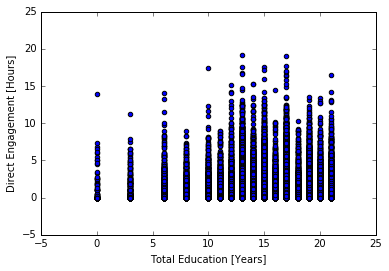

In [11]:
atus.plot(x = "Total Education [Years]", y = "Direct Engagement [Hours]", kind = "scatter")

This plot doesn't do a good job showing the trends ... or anything, really.  Have a look at the [plotting functions](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-plotting).  Which of these make sense?
* I would use a box plot, here.

[(0, 7)]

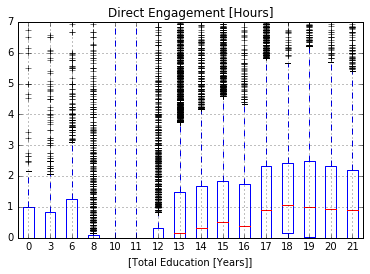

In [12]:
ax = atus.boxplot(by = "Total Education [Years]")

plt.suptitle("")
ax.set(ylim = (0, 7))

The large whiskers for the 0 IQR bins is actually a [recently-fixed bug](https://github.com/matplotlib/matplotlib/pull/5343).

This is sort of fine... not great looking.  

Let's import seaborn, and see if we can make it better:
* What is seaborn?  [Seaborn](https://seaborn.github.io/index.html) makes pretty plots from pandas dataframes.  
* It is based on [matplotlib](http://matplotlib.org/), which is _the_ plotting tool for python.  matplotlib is what gets called when you do `df.plot()`.
* Its defaults are aesthetically much better (except the fonts, which are unreadably small).

Take a look at the [gallery](https://seaborn.github.io/examples/index.html), and then check out the [API](https://seaborn.github.io/api.html) and the [boxplot](https://seaborn.github.io/generated/seaborn.boxplot.html#seaborn.boxplot).

In [13]:
import seaborn as sns
sns.set(font_scale = 1.3)

[(0, 7)]

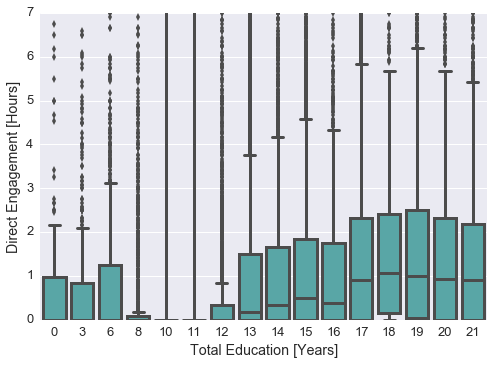

In [14]:
ax = sns.boxplot(data = atus, x = "Total Education [Years]", y = "Direct Engagement [Hours]", 
                 linewidth = 3, color = "aqua", saturation = 0.3)
ax.set(ylim = (0, 7))

In [15]:
ax.get_figure().savefig('blah.pdf')

Try some other possibilities too -- tryout lmplot, or regplot (thought I'm not sure what functional form this is).

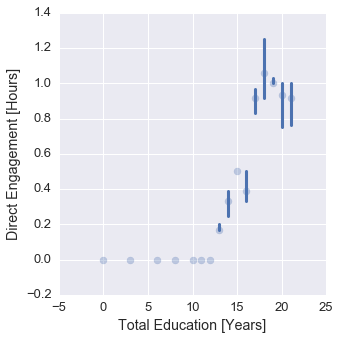

In [16]:
sns.lmplot(x = "Total Education [Years]", y = "Direct Engagement [Hours]", x_estimator = np.median, data = atus, fit_reg = False, scatter_kws={'alpha':0.3})

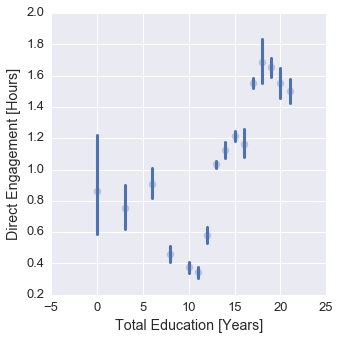

In [17]:
sns.lmplot(x = "Total Education [Years]", y = "Direct Engagement [Hours]", x_estimator = np.mean, data = atus, fit_reg = False, scatter_kws={'alpha':0.3})

This was a test of our skills **merging**, **calculating new columns**, and **plotting**.  A trifecta!

# Crime and Weather Revisited

On Monday we made a sort of silly example, showing that crime and temperature both go up in the summer.  Let's do a little bit better.  These data are derived by slicing, grouping, and averaging the crime data.  The weather data comes from sites like [these](https://www.wunderground.com/history/airport/KMDW/2016/10/18/DailyHistory.html?format=0), for Midway Airport, on Weather Undeground.

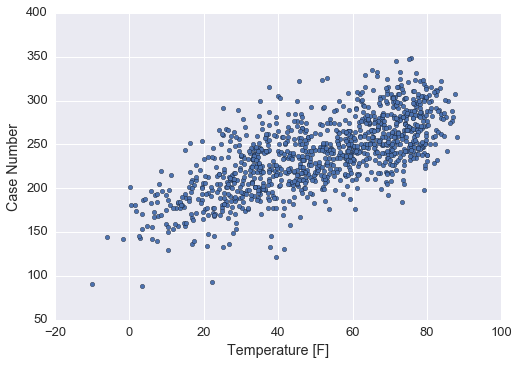

In [14]:
weather = pd.read_csv("ex/evening_temp_agg.csv",  index_col = 'Date', parse_dates = ['Date'])
crime   = pd.read_csv("ex/evening_crime_agg.csv", index_col = 'Date', parse_dates = ['Date'])
cw_merged = crime.join(weather)

cw_merged.plot(kind = "scatter", x = "Temperature [F]", y = "Case Number")

Instead of looking at the temperature, we can calculate movements with respect to its neighbors.  To do this, we'll need to use the pandas `shift()` function, documented [here](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.shift.html).  Basicaly, we want one copy one day ahead, another one day behind.  Then we'll take the difference of the current day to their average.

(If we wanted to be just a tad more sophisticated -- since adjacent days' weather is highly correlated -- we could use [rolling](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html) means, from a larger number of days.)

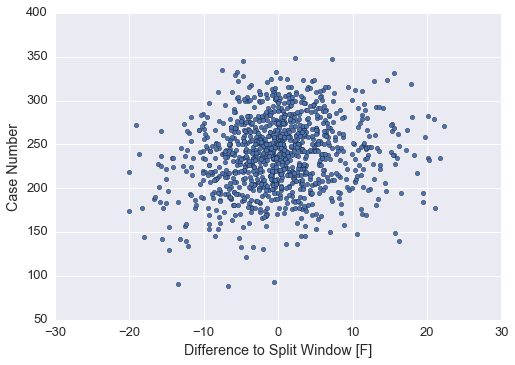

In [15]:
cw_merged['Difference to Split Window [F]'] = cw_merged['Temperature [F]'] - \
                                              0.5 * (cw_merged['Temperature [F]'].shift(-1) +
                                                     cw_merged['Temperature [F]'].shift(1))

cw_merged.dropna(inplace = True)

cw_merged.plot(kind = "scatter", x = "Difference to Split Window [F]", y = "Case Number")

The correlation is not as clear, but let's use Seaborn [regplot](https://seaborn.github.io/generated/seaborn.regplot.html#seaborn.regplot), to see the regression.

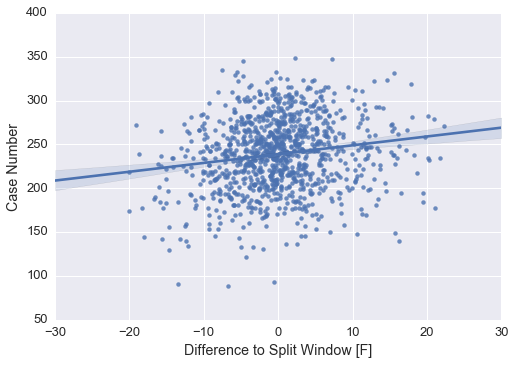

In [16]:
sns.regplot(data = cw_merged, x = "Difference to Split Window [F]", y = "Case Number")

That looks fairly significant.  We can actually measure it, using statmodels.  Import 

In [17]:
from scipy import stats
import statsmodels.formula.api as sm

There's nothing intuitive about the call to get OLS.  We create a simple model.

In [18]:
model = sm.ols(formula = 'NCrimes ~ DSWF', 
               data = cw_merged.rename(columns = {"Difference to Split Window [F]" : "DSWF",
                                                  "Case Number" : "NCrimes"})).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                NCrimes   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     30.01
Date:                Wed, 19 Oct 2016   Prob (F-statistic):           5.34e-08
Time:                        02:06:47   Log-Likelihood:                -5592.5
No. Observations:                1093   AIC:                         1.119e+04
Df Residuals:                    1091   BIC:                         1.120e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    238.9503      1.222    195.574      0.000       236.553   241.348
DSWF           1.0056      0.184      5.478      0.000         0.645     1.366
==============================================================================
Omnibus:                        6.439   Durbin-Watson:                   0.720
Prob(Omnibus):                  0.040   Jarque-Bera (JB):                6.445
Skew:                          -0.188   Prob(JB):                       0.0399
Kurtosis:                       3.003   Cond. No.                         6.66
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

You can also use the scipy [statistics functions](https://docs.scipy.org/doc/scipy/reference/stats.html#statistical-functions).  To check this impact of the temperature, we could run a linear regression:

In [19]:
slope, intercept, r_value, p_value, std_err = stats.linregress(cw_merged["Difference to Split Window [F]"], 
                                                               cw_merged["Case Number"])
print(slope/std_err)

5.47812978959


If, instead, we curious whether rain also decreases crime, a _t_-test might be appropriate.  It takes two series.  We want to give it the sample on days with and without rain.  How do we construct those?

In [20]:
stats.ttest_ind(cw_merged[cw_merged["Precipitation [In]"] == 0]["Case Number"],
                cw_merged[cw_merged["Precipitation [In]"] != 0]["Case Number"])

Ttest_indResult(statistic=3.5087662157137878, pvalue=0.00046853861836349485)

StatsModels and scipy are the two most-helpful packages for basic statistical analysis.  Statsmodels lets you design pretty-much arbitrarily complex models.

# A Matrix of Disadvantage

Though there's a fair degree of mobility in high school, Chicago elementary schools are "fairly neighborhood-centered."  I want to visualize the environments, using data from the [Illinois Report Card](http://illinoisreportcard.com/District.aspx?source=SchoolsInDistrict&Districtid=15016299025), matched with the city's [crime data](https://data.cityofchicago.org/view/5cd6-ry5g), and census data.  As we might imagine, students who face one challenge often face many.  There is a 'matrix' of disadvantage: poor kids' parents tend to be less-educated; they attend less-performing schools and see more crime.  

* The census variables are [listed here](http://api.census.gov/data/2014/acs5/variables.html).  I had converged on:
  * Educational attainment (bachelor's): B16010_041E and B16010_001E
  * Below the poverty line: B06012_002E and B06012_001E
* There is a function below, for pulling the data from the census.  We'll talk more about APIs in two weeks.  To use this, you'll have to [retrieve](http://www.census.gov/geo/reference/codes/cou.html) Illinois's and Cook County's FIPS code (Federal Information Processing Standard).
* In order to merge onto the census, I did a spatial join (week 8) of the crime data to census tracts, and similarly geocoded the addresses of the schools.  The crime counts per census tract are in `data/crime_tract_count.csv`.
* The school data is pulled from multiple sources.  You can see how this is done in `ex/school_scrape.py`.  We'll talk about scraping along with APIs.
* The school data is in two parts: `data/chicago_schools.csv` contains the "PARCC Proficiency (%)" (the test result we'll use), and `data/school_address_geocoded.csv` contains the `CensusTract`.  You can merge them on the `ISBE_ID` (Illinois State Board of Education).  Make sure you have the census tract at each level, for your final merge.

In [21]:
import requests

def get_census_data(variables = [], state = "", county = "*"):

    census_url = "http://api.census.gov/data/2014/acs5?for=tract:*&in=state:{}+county:{}&get=NAME,{}"
    addr = census_url.format(state, county, ",".join(variables))
    
    return requests.get(addr).json()

Start by importing the two school datasets and merging these.  Figure out which columns you really need in each, and drop schools with missing values.

In [22]:
df_sch_import = pd.read_csv("data/chicago_schools.csv", index_col = "ISBE_ID")
df_sch_import = df_sch_import[["Name", "PARCC Proficiency (%)", "Grades"]]

df_sch_geocode = pd.read_csv("data/school_address_geocoded.csv", index_col = "ISBE_ID", usecols = ["ISBE_ID", "CensusTract", "Address", "City", "State", "Zip", "Latitude", "Longitude", "CensusBlock", "CensusBlockGroup", "CensusCountyFips", "CensusStateFips"])
df_sch_geocode = df_sch_geocode[["CensusTract"]]
df_sch_geocode.rename(columns = {"CensusTract" : "Census Tract"}, inplace = True)

df_sch_merged = df_sch_import.join(df_sch_geocode)
df_sch_merged.dropna(inplace = True)

elementary = df_sch_merged[df_sch_merged["Grades"].str.contains("K")]
elementary_tract_quality = elementary.groupby("Census Tract").mean()

For this work, let's just look at elementary schools.  Very approximately, these are schools that have kindergartners.  Create a mask on grades that selects elementary schools (`x.str.contains(...)`).

In [23]:
elementary = df_sch_merged[df_sch_merged["Grades"].str.contains("K")]

Now import the crime counts, by census tract.

In [24]:
crime_tract_count = pd.read_csv("data/crime_tract_count.csv", index_col = "Census Tract")

Now use the function to get the census data.

In [25]:
variables = ["B16010_041E", "B16010_001E", "B06012_002E", "B06012_001E"]
census_resp = get_census_data(state = 17, county = 31, variables = variables)

The variable, `tract` is an integer, 100× larger than the census tracts.  In order to merge, we'll have to shrink it down.

The variables are numerators and denominators.  Have a look at the data, then create new columns for bachelor's and poverty percentages, by census tract.

In [26]:
census_df = pd.DataFrame(data = census_resp[1:], columns = census_resp[0])

census_df["Census Tract"] = census_df["tract"].astype(int)/100.
census_df.set_index("Census Tract", inplace = True)

for v in variables: census_df[v] = census_df[v].astype(int)
census_df["Percent Bachelor's"] = census_df["B16010_041E"] / census_df["B16010_001E"]
census_df["Percent Poverty"]    = census_df["B06012_002E"] / census_df["B06012_001E"]
census_df = census_df[["Percent Bachelor's", "Percent Poverty"]]

Finally, merge the three datasets -- the census, the crime, and the schools, together.

In [27]:
crime_schools = pd.concat([crime_tract_count, elementary_tract_quality, census_df], axis = 1)

Check out the `scatter_matrix` (`pd.tools.plotting.scatter_matrix(df)`), to view correlations between the four variables.

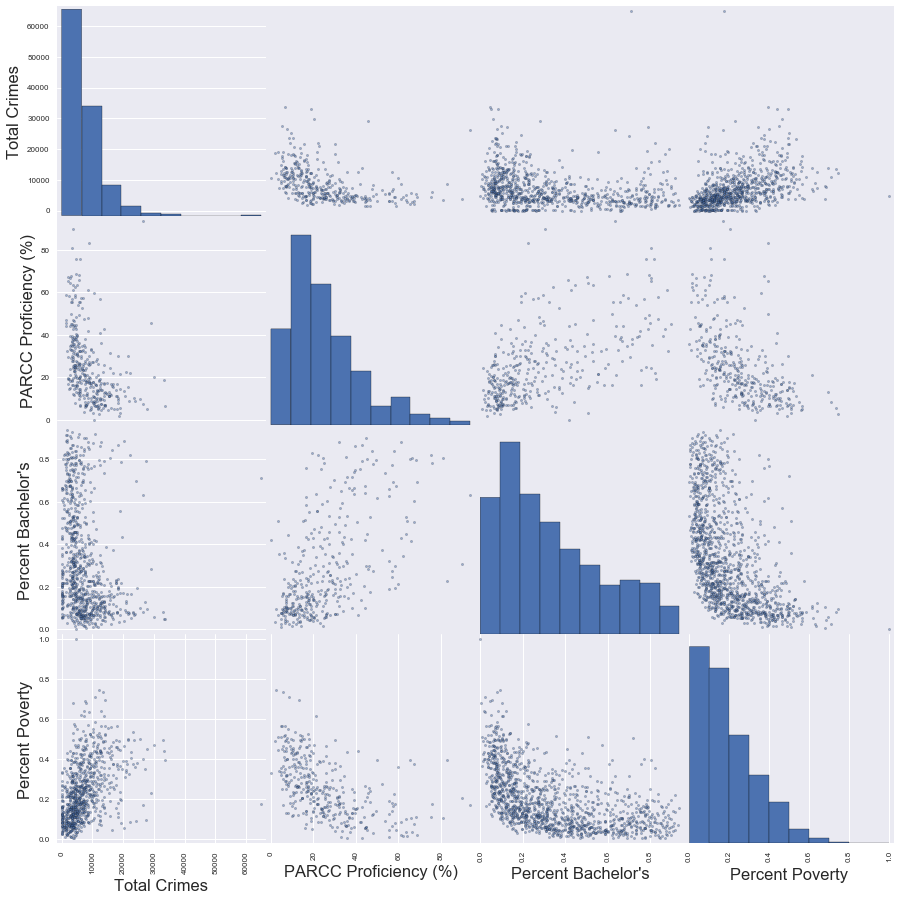

In [28]:
sns.set(font_scale = 1.5)
fig = pd.tools.plotting.scatter_matrix(crime_schools, figsize = (15, 15))